# Machine Learning in Python - Project 1


Yalda Janebdar, Harry Richardson, William Brazier, Michael Mooney

## 0. Setup

In [1]:
# Add any additional libraries or submodules below
from difflib import SequenceMatcher
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import calendar
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

# Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
d = pd.read_csv("the_office.csv")

## 1. Introduction

We have been tasked with advising on the creation of a reunion episode for *The Office*. In this report, we begin by using data derived from the `shrutepy` package (MLP, 2022), and proceed by cleaning the data, removing any entries which are less relevent (see section 2).  

We then proceed to create a heatmap, allowing us to spot any high correlations between the features, and to combine these features where there is a clear link. One place where we do this, for example, is with `n_lines` and `n_words`, combining these to make the new `words_per_line` feature. 

After correcting our data, we consider a number of approaches, including the  linear regression, lasso regression, K-means clustering and DB scan methods, for our model. In using these models, it became obvious that further correction of our data set was required. The final model, capturing any relationships that exist between the features and imdB ratings, is used to predict which criteria would make the ideal reunion episode. 



## 2. Exploratory Data Analysis and Feature Engineering

### Initial inspection before data cleaning

To analyse the data and make any potential changes, we copy the data into a new variable `df`. We first check the data types of each column. This gives us a sense of the types of data we're working with.

In [3]:
df = d.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


We then check that we do not have any duplicate rows within our data, as duplicate rows would skew our data.

In [4]:
#We first need to check if any of the rows are duplicated
xs = df.duplicated()
duplicates = False
for i in xs:
  if i:
    print("There are duplicated values")
    break

Some of the episodes appear to be made up of two parts. In these cases these episodes are considerably larger than a regular episode. This is a very obvious skew in the dataset.
Thus, as a naive approch we shall divide `n_lines`, `n_directions` and `n_words` by $2$ in the cases where the episode is a two-parter. This is given by the following code:

In [5]:
lst = ["n_lines", "n_directions", "n_words"]
for i, k in zip(df["episode_name"], range(len(df.episode_name))):
  if "Parts" in i:
    newRow = df.iloc[k]
    for j in lst:
      newRow[j] = newRow[j]/2
      df[j].iloc[k] = df[j].iloc[k]/2
    df = df.append(newRow)

df = df.reset_index(drop=True)

### Correcting Errors Within the DataFrame

From inspecting the DataFrame, we notice two main problems with how the data is arranged.

1) The `writer` and `main_char` columns contain each of the writers and main characters, while being separated by a semicolon. To be able to analyse either fo these columns (i.e. by one-hot encoding), we will need to separate these names so we can access them separately.

2) There are spelling mistakes within the `director` and `writer` columns. For example, "Greg Daniels" is the director of episode $5$ of the show, however in episode $13$, his name is spelled as "Greg Daneils". This must be corrected before we analyse anything further.

We first split the `writer` and `main_char` columns:

In [6]:
processed = False # Don't process if it has already been processed!!!

In [7]:
# Only process if it hasn't been done already
if (not processed):
  j = 0
  for i in df["main_chars"]:
    m = i.split(";")
    df["main_chars"][j] = m
    j+=1

  j = 0
  for i in df["writer"]:
    m = i.split(";")
    df["writer"][j] = m
    j+=1
  
  display(df[["writer", "main_chars"]][:3])
else:
  display(df[["writer", "main_chars"]][:3])

,writer,main_chars
0,"[Ricky Gervais, Stephen Merchant, Greg Daniels]","[Angela, Dwight, Jim, Kevin, Michael, Oscar, P..."
1,[B.J. Novak],"[Angela, Dwight, Jim, Kelly, Kevin, Michael, O..."
2,[Paul Lieberstein],"[Angela, Dwight, Jim, Kevin, Meredith, Michael..."


We now correct the spelling mistakes. The lists `corrected_writers` and `corrected_directors` had their names manually entered after checking their spellings from another source. We will correct the errors using a similarity measure, `SequenceMatcher`. It outputs a value between $0$ and $1$, where the output is $1$ if the two strings are the same and $0$ if they share no identical characters. We correct the name to the correct spelling should the similarity be greater than $0.8$.

In [8]:
# List of the correct writer names
corrected_writers = ["Ricky Gervais", "Stephen Merchant", "Greg Daniels", "B.J. Novak", "Paul Lieberstein",
                     "Michael Schur", "Mindy Kaling", "Gene Stupnitsky", "Lee Eisenberg", "Larry Wilmore",
                     "Jennifer Celotta", "Steve Carell", "Brent Forrester", "Justin Spitzer", "Caroline Williams",
                     "Lester Lewis", "Ryan Koh", "Aaron Shure", "Charlie Grandy", "Anthony Q. Farrell",
                     "Warren Lieberstein", "Halsted Sullivan", "Daniel Chun", "Jason Kessler", "Jonathan Hughes",
                     "Peter Ocko", "Jon Vitti", "Carrie Kemper", "Steve Hely", "Robert Padnick", "Amelie Gillette",
                     "Allison Silverman", "Dan Greaney", "Owen Ellickson", "Jonathan Green", "Gabe Miller",
                     "Dan Sterling", "Niki Schwartz-Wright", "Graham Wagner", "Tim McAuliffe"]

# List of the correct director names
corrected_directors = ["Ken Kwapis", "Ken Whittingham", "Bryan Gordon", "Greg Daniels", "Amy Heckerling",
                       "Paul Feig", "Charles McDougall", "Dennie Gordon", "Victor Nelli Jr.", 
                       "Roger Nygard", "Randall Einhorn", "Miguel Arteta", "Tucker Gates", "Jeffrey Blitz",
                       "Harold Ramis", "Julian Farino", "Joss Whedon", "J.J. Abrams", "Craig Zisk",
                       "Jason Reitman", "Jennifer Celotta", "David Rogers", "Stephen Merchant",
                       "Dean Holland", "Asaad Kelada", "Steve Carell", "Brent Forrester",
                       "Lee Eisenberg", "Gene Stupnitsky", "Paul Lieberstein", "Reginald Hudlin",
                       "Seth Gordon", "B.J. Novak", "John Krasinski", "Marc Webb", "Matt Sohn",
                       "Mindy Kaling", "Rainn Wilson", "John Scott", "Alex Hardcastle", "Danny Leiner",
                       "Michael Spiller", "Troy Miller", "Charlie Grandy", "Ed Helms", "Eric Appel",
                       "Brian Baumgartner", "Claire Scanlon", "Daniel Chun", "Bryan Cranston",
                       "Rodman Flender", "Kelly Cantley-Kashima", "Lee Kirk", "Jon Favreau",
                       "Jesse Peretz"]

#The function determines how similar two words are on a scale of 0 to 1, if 1 then the words are the same
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

#For errors made in director we have:
num_errors = 0
for i in corrected_directors:
  counter = 0
  for j in df["director"]:
      if similar(i, j) !=1 and similar(i,j)>0.8:
        df["director"][counter] = i
        num_errors += 1
      counter += 1

print("Amount of spelling errors made in the directors column is: "+ str(num_errors))

#For errors made in writers we have:
num_errors = 0
for i in corrected_writers:
  counter = 0
  for l in df["writer"]:
    sub_counter = 0
    for j in l:
      if similar(i, j) !=1 and similar(i,j)>0.8:
        df["writer"][counter][sub_counter] = i
        num_errors += 1
      sub_counter +=1 
    counter += 1
      

print("Amount of spelling errors made in the writers column is: "+ str(num_errors))

Amount of spelling errors made in the directors column is: 6
Amount of spelling errors made in the writers column is: 4


### Engineering for `n_words`, `n_lines`, `n_directions` and `n_speak_char`
We wish to check the correlation between numerical data within our DataFrame. This will tell us whether certain columns are too similar to each other and if they should be combined to reduce our number of features.

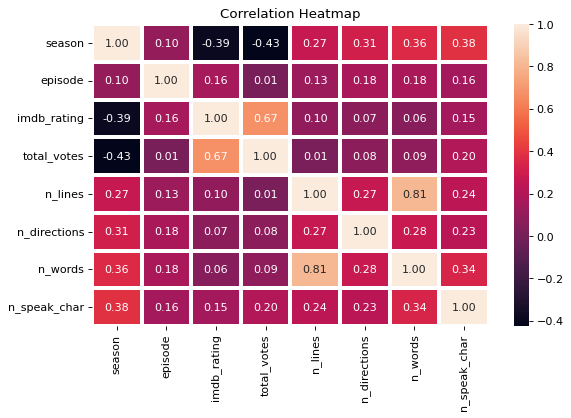

In [9]:
#Correlation between numerical values before data cleaning
df_= df.copy()
df_=df_.drop("episode_name", axis=1)
df_=df_.drop("director", axis=1)
df_=df_.drop("writer", axis=1)
df_=df_.drop("main_chars", axis=1)
sns.heatmap(df_.corr(), annot=True, fmt='.2f', linewidths=2)
plt.title("Correlation Heatmap")
plt.show()

As we can see from the heatmap for this set of features, `n_words` and `n_lines` are highly correlated at $0.81$. In order to combat this we divide `n_words` by `n_lines` to get a new column, `words_per_line`.

In [10]:
if "n_lines" in df.columns:
  df["words_per_line"] = df["n_words"]/df["n_lines"] #Create the new column "words_per_line"
  df = df.drop("n_lines", axis=1) #Remove the old column "n_lines"

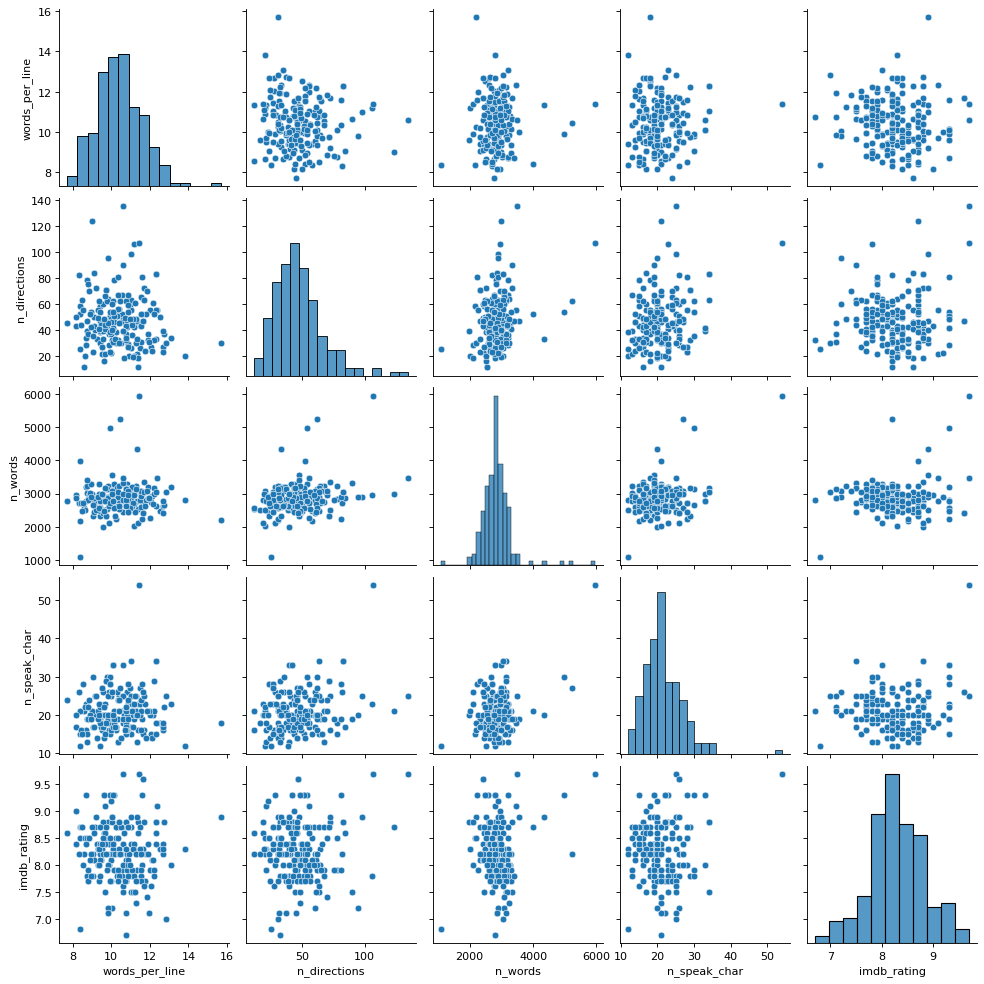

In [11]:
g = sns.pairplot(df[["words_per_line", "n_directions", "n_words", "n_speak_char", "imdb_rating"]])

We notice from the pairplot above that there is an outlier in `n_speak_char`. This outlier is the finale episode, we remove this as it turns out to be an outlier in a large number of categories.

In [12]:
df = df.drop(df["n_speak_char"].idxmax()) #Drop the finale episode

Now that we have finished all feature engineering for `n_lines`, `n_words`, `n_directions` and `n_speak_char` we standardise them since they have different orders of magnitude.

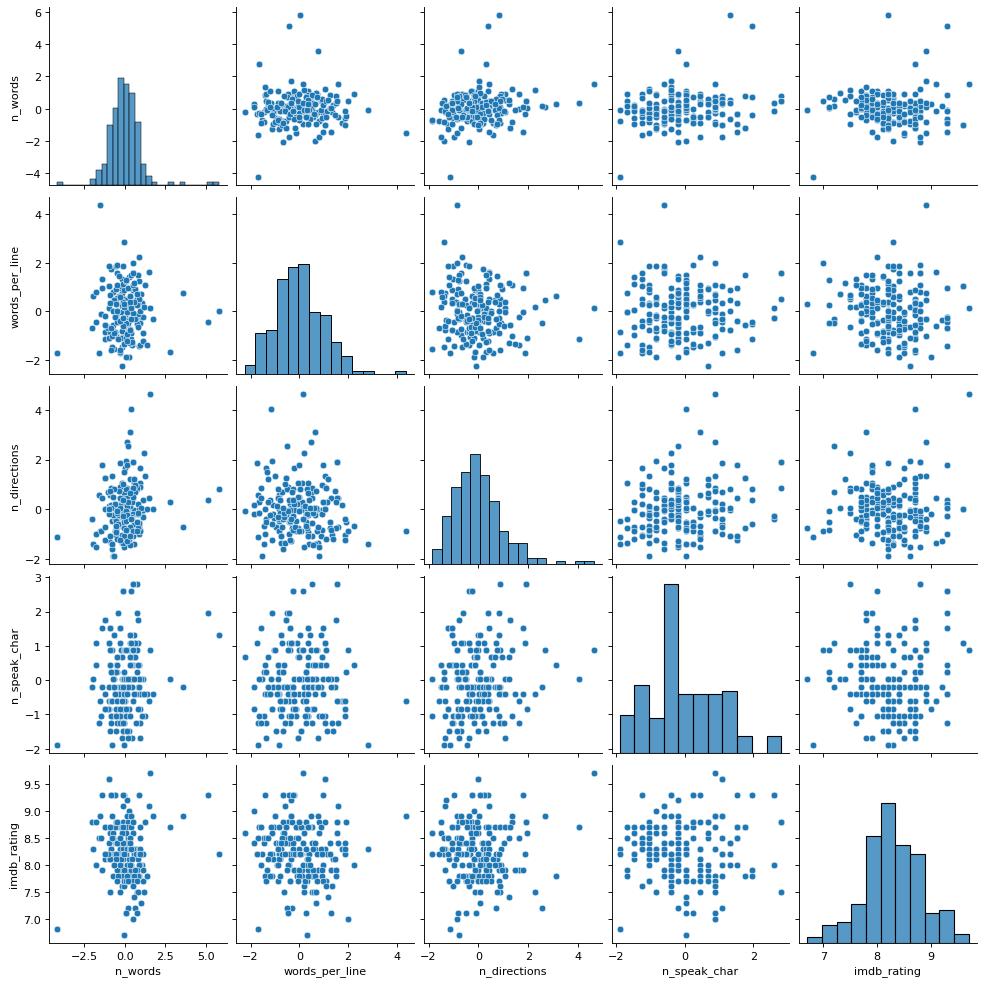

In [13]:
##Standardise numerical variables
df[["n_words", "words_per_line", "n_directions", "n_speak_char"]]=(df[["n_words", "words_per_line", "n_directions", "n_speak_char"]]-df[["n_words", "words_per_line", "n_directions", "n_speak_char"]].mean())/df[["n_words", "words_per_line", "n_directions", "n_speak_char"]].std()
h = sns.pairplot(df[["n_words", "words_per_line", "n_directions", "n_speak_char", "imdb_rating"]])

### Air Date Analysis

Consider the air dates of each episode. We want to determine if there is a link between the days the episodes are aired and imdb rating. Firstly, we find which days the episodes have been aired on.

<BarContainer object of 3 artists>

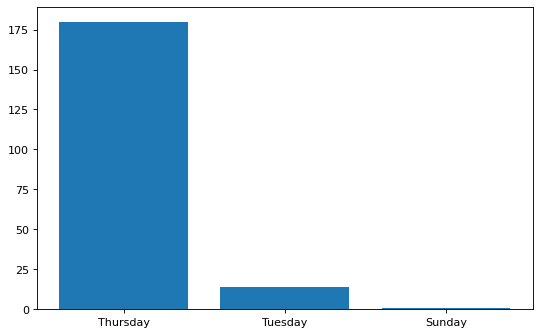

In [14]:
df_=df.copy()
df_['air_date'] = pd.to_datetime(df_['air_date'])
date_dict = {}
j = 0
for i in df_["air_date"]:
  day = calendar.day_name[i.weekday()]
  if day in date_dict:
    date_dict[day] = [date_dict[day][0]+1,date_dict[day][1]+[df_["episode_name"][j]]]
  else:
    date_dict[day] = [0, [df_["episode_name"][j]]]
    j+=1

plt.bar(list(date_dict), [i[0] for i in date_dict.values()])

From the above bar chart, we note that every episode was either aired on a Tuesday or Thursday (apart from one episode which was aired on a Sunday). As the majority of episodes are aired on Thursday, we can make no conclusions about the day of week in which the episodes are aired. Futhermore, it may have been reasonable that certain months of the year have a higher rating. However, this is not the case as can be seen below.

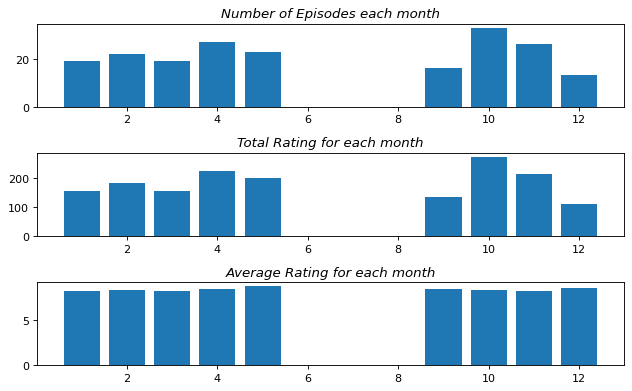

In [15]:
df = df.reset_index(drop=True)
j=0
months=[]
for i in df["air_date"]:
  m = i.split("-")
  df["air_date"][j] = m
  months = months + [m[1]]
  j+=1
months = [int(i) for i in months]
dict_months = {}
j=0
for m in months:
  if m in dict_months:
    a, b = dict_months[m]
    dict_months[m]=(a+1, b+df["imdb_rating"][j])
  else:
    dict_months[m]=(1, df["imdb_rating"][j])
  j+=1
fig, axs = plt.subplots(3)
axs[0].bar(list(dict_months), [a for (a,b) in dict_months.values()])
axs[0].set_title('Number of Episodes each month', fontstyle='italic')
axs[1].set_title('Total Rating for each month', fontstyle='italic')
axs[1].bar(list(dict_months), [b for (a,b) in dict_months.values()])
axs[2].bar(list(dict_months), [b/a for (a,b) in dict_months.values()])
axs[2].set_title('Average Rating for each month', fontstyle='italic')
fig.tight_layout()

As we can see above, the average rating for each month is incredibly similar. Since the day and month an episode has been released does not tell us anything, we will drop the column ``air_date``.

In [16]:
df=df.drop("air_date", axis=1)

### Season and Episode

Our aim is to find suitable parameters for a reunion episode, so we are unable to specify an episode number. Thus, we drop the episode number for each episode.

In [17]:
df=df.drop("episode", axis=1)

In a similar vein, the ``episode_name`` is just a unqiue identifier to a particular episode. Doing any analysis on the name itself would require sophisticated ML methods. Other examples may include having popular character names in the title. We, however, ignore such an analysis as it would require factors outside of our data set.

In [18]:
df=df.drop("episode_name", axis=1)

Now, a hypothesis may be that certain seasons have a higher rating than others, and thus, when deciding which episode to run, a recommendation may be that you want to emulate the theme of that particular season. Indeed this turns out to be the case, as can be seen below, there is some variance in `imdb_rating` between different seasons.

<BarContainer object of 198 artists>

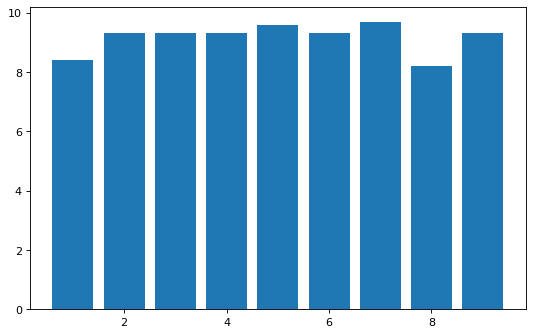

In [19]:
plt.bar(df["season"], df["imdb_rating"])

### One-Hot Encoding

Now that we have separated our categorical variables into a format we can work with, we can perform one-hot encoding onto these categorical variables. 

Additionally, we remove any directors or writers who wrote/directed fewer than 4 episodes. Our justification for doing this is that we cannot safely judge whether a writer is a good fit if we only have a small sample of their work to judge them by. Writers who have only written a small number of episodes, but whose episodes have high imdb scores, are not the perfect choice. We remove these writers from our data set to ensure that they do not appear as the optimal option for a writer when we look for a correlation between writers and ratings.

Furthermore, after trial and error, we found fitting a model successfully to be quite difficult if we try to do so without removing writers who had contributed a very small amount of episodes. In fact, attempting to fit a linear or lasso model, without accounting for these writers and directors, lead to unacceptably large RMSE values.

In [20]:
mlb_writers = MultiLabelBinarizer()
encoded_writers = pd.DataFrame(mlb_writers.fit_transform(df["writer"]),
                   columns=mlb_writers.classes_)

# Encoding on the main characters
mlb_main_chars= MultiLabelBinarizer()
encoded_main_chars = pd.DataFrame(mlb_main_chars.fit_transform(df["main_chars"]),
                   columns=mlb_main_chars.classes_)

encoded_directors = pd.get_dummies(df.director, prefix='Director', prefix_sep = " ")

# Creating a new dataframe for the encoded columns
df = pd.concat([df, encoded_directors, encoded_writers, encoded_main_chars], 
                  axis = 1)
df=df.drop(["director", "writer", "main_chars"], axis=1)

In [21]:
## Remove Writers and Directors who feature a low number of times
nt = 4
for col in df.drop(["words_per_line", "total_votes", "n_directions", "n_words", "n_speak_char"], axis=1):
    if np.sum(df[col].astype(int))<nt:
        df=df.drop(col, axis=1)
print(df.shape)

(198, 57)




### Rating and total votes

We want to be able to distingush between episodes that have the same rating as others but have more or less votes. For example, in the following scatter plot, there are episodes which have similar rating yet have completely different amounts of votes. On the lower end of the scale, we would expect such episodes to be worse and on the middle to higher end, we would expect the episodes to be better. Therefore, we also introduce a ``trustScore`` to distingush these patterns.

Text(0, 0.5, 'imdb Rating')

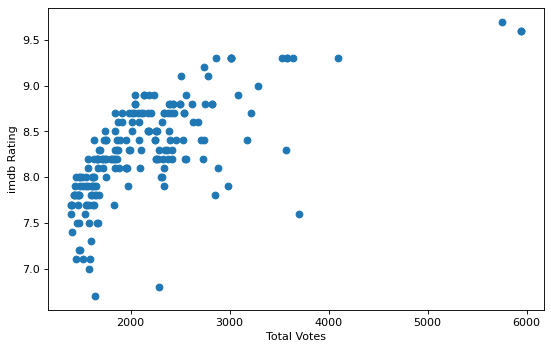

In [22]:
#Need to determine if weight on votes needs to be done eg low votes to high rating vs high votes to low rating
plt.scatter(df["total_votes"], df["imdb_rating"])
plt.xlabel("Total Votes")
plt.ylabel("imdb Rating")

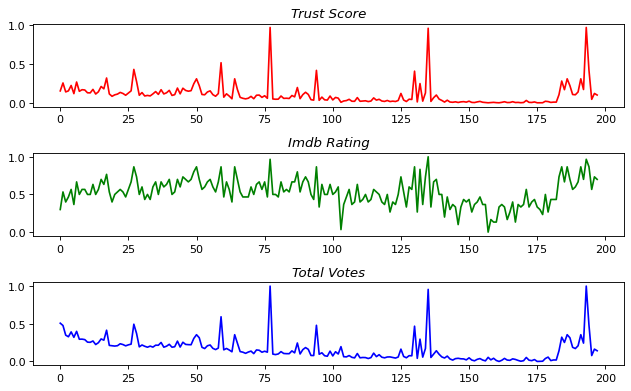

In [23]:
import numpy as np
from sklearn import preprocessing
i=0
if i == 1:
    scaler = preprocessing.StandardScaler()
else:
    scaler = preprocessing.MinMaxScaler()

normVotes = np.array(df["total_votes"]).reshape(-1,1)
normVotes = scaler.fit_transform(normVotes)
normRating = np.array(df["imdb_rating"]).reshape(-1,1)
normRating = scaler.fit_transform(normRating)

trustScore=[]
k=0
for i in normVotes:
    trustScore = trustScore + [i*normRating[k]]
    k+=1

xs = [i for i in range(len(df))]
fig, axs = plt.subplots(3)
axs[0].plot(xs,trustScore, color='r')
axs[1].plot(xs,normRating, color='g')
axs[2].plot(xs,normVotes, color='b')
axs[0].set_title('Trust Score', fontstyle='italic')
axs[1].set_title('Imdb Rating', fontstyle='italic')
axs[2].set_title('Total Votes', fontstyle='italic')
fig.tight_layout()

We want to give an idea of how "trustworthy" the rating is, for example, consider an episode with a rating of 6.9 with 1000 votes versus another with a rating of 7.0 with 100 votes. We therefore trust the latter less despite the higher rating since it has so few votes. In that sense, after standardisation, it should have the lower ``trustScore`` of the pair. On the other end, we can see that episodes with more votes and the same rating as other episodes have a higher ``trustScore``. We thus remove `total_votes` and `imdb_rating` and replace them with `trustScore` as it acts as a combination of the two.

In [24]:
df=df.drop(["total_votes", "imdb_rating"], axis=1)
df["trust_score"]=trustScore

This finishes off section 2. Our data now looks like the following.

In [25]:
display(df)

,season,n_directions,n_words,n_speak_char,words_per_line,Director B.J. Novak,Director Brent Forrester,Director Charles McDougall,Director David Rogers,Director Greg Daniels,...,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby,trust_score
0,1,-1.021862,-0.196079,-1.257249,1.348278,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,[0.15233809001097706]
1,1,-1.387359,-0.073151,-1.899387,2.835939,0,0,0,0,0,...,1,0,1,1,1,0,1,1,1,[0.25443102817416774]
2,1,-1.335145,-0.167154,-1.685341,0.775069,0,0,0,0,0,...,1,1,1,1,1,0,1,1,0,[0.1396267837541165]
3,1,-1.178503,0.242606,-1.471295,1.394196,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,[0.1529601170874497]
4,1,0.126843,-0.967391,-0.615112,0.150616,0,0,0,0,1,...,1,0,1,1,1,1,1,1,0,[0.222188071716063]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,5,-0.003692,-0.990290,1.097255,1.042461,0,0,0,0,0,...,1,1,1,1,1,1,0,1,0,[0.9666666666666668]
194,6,-0.264761,-0.116537,2.595576,-0.253366,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,[0.4159238931577024]
195,6,-1.047969,0.329378,1.311301,-0.741753,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,[0.0444127332601537]
196,7,-0.369189,0.381201,1.097255,-0.325506,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,[0.1199414562751556]


## 3. Model Fitting and Tuning

On this dataset, we considered many models. We considered linear regression, lasso regression, K-means clustering and DB scan. Firstly, without removing writers and directors who had not contributed many episodes, we found that every method was unsuitable as the root mean squared error (RMSE) for linear regression was very large, Lasso regression set every weight coefficient to $0$ and K-means clustering identified only a single cluster. At this point, we decided that using a classification method would not be suitable since both clustering models simply claimed that we had one large cluster. Obviously, that result is unhelpful.

In order to decrease noise in the dataset we decided to remove writers and directors who had contributed to a small number of episodes. This led to a much smaller error for linear regression and we had non-zero coefficients in lasso, although lasso had the smallest error of the two. 

Using linear and lasso regressions, we tried two different approaches:

1. choosing to remove entire episodes by writers and directors who had contributed less than four episodes, however, this resulted in the dataset being far too homogeneous. We ended up with all coefficients from Lasso equalling zero.

2. removing one hot encoded columns of writers and directors who contribute to less than 4 episodes instead of removing the entire episode gave non-zero coefficients in Lasso.

In both cases, lasso regression gave a smaller RMSE than using linear regression. Therefore, we will only focus on lasso regression as our model.

### Lasso Regression
With lasso regression, we varied the penalty coefficient $\alpha$. We found that $\alpha=0.004$ gave the smallest RMSE, so, for our model we will use this value.


Our complete pipeline is implemented below.


In [26]:
# List of the correct writer names
corrected_writers = ["Ricky Gervais", "Stephen Merchant", "Greg Daniels", "B.J. Novak", "Paul Lieberstein",
                        "Michael Schur", "Mindy Kaling", "Gene Stupnitsky", "Lee Eisenberg", "Larry Wilmore",
                        "Jennifer Celotta", "Steve Carell", "Brent Forrester", "Justin Spitzer", "Caroline Williams",
                        "Lester Lewis", "Ryan Koh", "Aaron Shure", "Charlie Grandy", "Anthony Q. Farrell",
                        "Warren Lieberstein", "Halsted Sullivan", "Daniel Chun", "Jason Kessler", "Jonathan Hughes",
                        "Peter Ocko", "Jon Vitti", "Carrie Kemper", "Steve Hely", "Robert Padnick", "Amelie Gillette",
                        "Allison Silverman", "Dan Greaney", "Owen Ellickson", "Jonathan Green", "Gabe Miller",
                        "Dan Sterling", "Niki Schwartz-Wright", "Graham Wagner", "Tim McAuliffe"]
    
# List of the correct director names
corrected_directors = ["Ken Kwapis", "Ken Whittingham", "Bryan Gordon", "Greg Daniels", "Amy Heckerling",
                        "Paul Feig", "Charles McDougall", "Dennie Gordon", "Victor Nelli Jr.", 
                        "Roger Nygard", "Randall Einhorn", "Miguel Arteta", "Tucker Gates", "Jeffrey Blitz",
                        "Harold Ramis", "Julian Farino", "Joss Whedon", "J.J. Abrams", "Craig Zisk",
                        "Jason Reitman", "Jennifer Celotta", "David Rogers", "Stephen Merchant",
                        "Dean Holland", "Asaad Kelada", "Steve Carell", "Brent Forrester",
                        "Lee Eisenberg", "Gene Stupnitsky", "Paul Lieberstein", "Reginald Hudlin",
                        "Seth Gordon", "B.J. Novak", "John Krasinski", "Marc Webb", "Matt Sohn",
                        "Mindy Kaling", "Rainn Wilson", "John Scott", "Alex Hardcastle", "Danny Leiner",
                        "Michael Spiller", "Troy Miller", "Charlie Grandy", "Ed Helms", "Eric Appel",
                        "Brian Baumgartner", "Claire Scanlon", "Daniel Chun", "Bryan Cranston",
                        "Rodman Flender", "Kelly Cantley-Kashima", "Lee Kirk", "Jon Favreau",
                        "Jesse Peretz"]

# List to store every feature in the dataset after one hot encoding
allCol = []

# List to store the features used for the model
finalCols = []

In [27]:
def writerCharSplit(df):
    # Split the writer column into a list instead of a string. The same is done with main_chars
    for i, j in zip(df["main_chars"], range(len(df.main_chars))):
        if len(i[0])==1:
            m = i.split(';')
            df["main_chars"].iloc[j] = m
        
    for i, j in zip(df["writer"], range(len(df.writer))):
        if len(i[0])==1:
            m = i.split(';')
            df["writer"].iloc[j] = m
        
    return df

def similar(a, b):
    # This function determines how similar two words are on a scale of 0 to 1, if 1 then the words are the same
    return SequenceMatcher(None, a, b).ratio()

def fixSpelling(df):
    # This function fixes spelling errors in the writer and director columns
    # Fix errors in director column
    for i in corrected_directors:
        for k, j in zip(range(len(df.director)), df["director"]):
            if similar(i, j) !=1 and similar(i,j)>0.8:
                df["director"].iloc[k] = i
    
    #For errors made in writers we have:
    for i in corrected_writers:
        for k, l in zip(range(len(df.writer)), df["writer"]):
            for j, p in zip(l, range(len(l))):
                if similar(i, j) !=1 and similar(i,j)>0.8:
                    df["writer"].iloc[k][p] = i
    
    return df

def oneHotEncoding(df):
    # This function does onehotencoding for writers, directors and main characters
    encoded_writers = pd.get_dummies(df.writer.apply(pd.Series).stack()).sum(level=0)
    
    # Encoding on the main characters
    encoded_main_chars = pd.get_dummies(df.main_chars.apply(pd.Series).stack()).sum(level=0)
    
    # Some directors are also writers, we account for the fact that they might perform differently in different roles.
    encoded_directors = pd.get_dummies(df.director, prefix='Director', prefix_sep = " ")

    # Creating a new dataframe for the encoded columns
    df = pd.concat([df, encoded_directors, encoded_writers, encoded_main_chars], 
                          axis = 1)
    
    # List of all onehotencoding column headings
    allOHECol = [*["Director "+i for i in corrected_directors], *corrected_writers]
    
    for i in allOHECol:
        if not (i in df.columns):
            df[i]=0
    
    return df

def removeWD(df):
    # This function removes writers and directors who feature in less than 4 episodes
    if len(allCol)==0:
        nt = 4
        for col in df.drop(["director", "writer", "main_chars", "air_date", "episode_name"], axis=1).columns:
            if np.sum(df[col])<nt:
                df=df.drop(col, axis=1)
            else:
                allCol.append(col)
    else:
        for i in df.columns:
            if not (i in allCol):
                df=df.drop(i, axis=1)
    return df
    

def trustScore(df):
    # This function generates a column called trust_score which is a combination of imdb_rating and total_votes
    normRating = []
    normVotes = []
    for i, k in zip(df["imdb_rating"], range(len(df.imdb_rating))):
        normRating = normRating + [(i-df["imdb_rating"].min())/(df["imdb_rating"].max()-df["imdb_rating"].min())]

    for i, k in zip(df["total_votes"], range(len(df.total_votes))):
        normVotes = normVotes + [(i-df["total_votes"].min())/(df["total_votes"].max()-df["imdb_rating"].min())]

    trustScore=[]
    for i, k in zip(normVotes, range(len(normVotes))):
        trustScore = trustScore + [i*normRating[k]]
        
    df["trust_score"]=trustScore
    return df.drop(["imdb_rating", "total_votes"], axis=1)

def fixNumerical(df):
    # This function applies the changes we decide to make to the n_* columns
    df["words_per_line"] = df["n_words"]/df["n_lines"] #Create the new column "words_per_line"
    df = df.drop("n_lines", axis=1) #Remove the old column "n_lines"
    # Standardise all variables
    for a in ["n_words", "words_per_line", "n_directions", "n_speak_char"]:
      df[a]=(df[a]-df[a].mean())/df[a].std()
    return df

def dropUnusedColumns(df):
    if "air_date" in df.columns:
        df = df.drop(["air_date", "episode_name", "writer", "director", "main_chars"], axis=1)
    df = df.drop(["episode"], axis=1)
    if len(finalCols)==0:
        for i in df.columns:
            finalCols.append(i)
    return df

def PartTwo(df):
  lst = ["n_lines", "n_directions", "n_words"]
  for i, k in zip(df["episode_name"], range(len(df.episode_name))):
    if "Parts" in i:
      newRow = df.iloc[k]
      for j in lst:
        newRow[j] = newRow[j]/2
        df[j].iloc[k] = df[j].iloc[k]/2
      df = df.append(newRow)
  return df

# Transform all functions
SP = FunctionTransformer(writerCharSplit)
FS = FunctionTransformer(fixSpelling)
OH = FunctionTransformer(oneHotEncoding)
RM = FunctionTransformer(removeWD)
FN = FunctionTransformer(fixNumerical)
DU = FunctionTransformer(dropUnusedColumns)

In [28]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

df = d.copy()
df = df.drop(df["n_speak_char"].idxmax()) # Drop the finale episode
df = PartTwo(df)
df = df.reset_index(drop=True)

allCol = []
finalCols = []

# We use the Lasso model
reg = Lasso(alpha=0.004)

pipe = Pipeline([
    ("writerCharSplit", SP),
    ("fixSpelling", FS),
    ("oneHotEncoding", OH),
    ("removeWD", RM),
    ("fixNumerical", FN),
    ("dropUnusedColumns", DU),
    ("model", reg)
])

if "imdb_rating" in df.columns:
    df = trustScore(df)

X = df.drop('trust_score',axis=1) # Independent variable
y = df['trust_score'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

for f in [X_train, y_train, X_test, y_test]:
    f=f.reset_index(drop=True)

pipe.fit(X_train, y_train)
print("Pipeline fitted successfully!")

Pipeline fitted successfully!


In [29]:
from sklearn.metrics import mean_squared_error
def model_fit(m, X, y, plot = False):
    ## This method was copied from workshop 5!
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

# Test the pipeline
print("RMSE: ",model_fit(pipe, X_test, y_test))

RMSE:  0.13127263235776157


In [30]:
coefsdict=dict(zip(finalCols, pipe.named_steps['model'].coef_))
sortcoefs = sorted(coefsdict.items(), key=lambda x: x[1], reverse=True)
print("Good Attributes:")
for i in sortcoefs:
    if i[1]>0:
        print(i)

print("\nBad Attributes:")
for i in sortcoefs:
    if i[1]<0:
        print(i)

Good Attributes:
('Director Paul Feig', 0.042362870723582594)
('Paul Lieberstein', 0.02726773178849996)
('n_speak_char', 0.014450732560027733)

Bad Attributes:
('season', -0.020651600328755536)


## 4. Discussion & Conclusions
### Best Possible Episode - Lasso
We give the cast which we would pick for the best possible reunion episode (in order of importance):
* Director: Paul Feig.
* Writer: Paul Lieberstein.

In general, episodes with a high number of speaking characters perform well. Additonally, we recommend emulating the themes and style of earlier seasons since these seem to weigh positively. We found that the main characters do not affect the rating of an episode. This makes sense since most of the main characters appear in a huge proportion of the episodes, meaning that they shouldn't be a big factor in determining which episode is better than another.

### Improvements
#### Relationship between writers and other features
One area of improvement for our model would be to draw a relationship between the writers and the number of words and lines. The main obstacle to this is that certain episodes have been written and directed by multiple writers and directors, therefore a simple heat map or correlation would be difficult to draw. Some writers and directors may have different styles, we could have found out which writers generally write shorter scripts, for example.

#### Pairing writers and directors
It is also possible that specific directors work particularly well with specific writers and cast members. These links would be very difficult to quantify as there are too many degrees of freedom. Further research could be conducted on finding a model which could incorporate this.

#### Larger feature set
Another area of improvement would be to use a larger feature set. The initial stages of data processing involved dropping certain features (such as air date), as we were unable to spot any clear correlation between said features and the IMDb ratings. However, had we used contextual data, such as looking at the repurcussions of airing the show directly after the Superbowl, or airing it at the same time as other popular tv shows, we might have been able to find a trend behind these occurences. We didn't take these measures since it would likely only serve to increase noise in the dataset. We would simply recommend not airing the episode at the same time as an event such as the Superbowl.

Additionally, data taken directly from `schrute` could be used, although we elected to work only with the dataset we were given. It should be noted that the data from `schrute` contained a huge amount of extra information such as every line spoken by a given character. This could be used to further improve the accuracy of the model.

#### Trust score
The `trust_score` provides a good measure which determines the trustworthiness of a given episode, rather than just the rating. However, there are many other ways this could have been implemented. To begin with we used the code, `preprocessing.MinMaxScaler()`. Instead we could have used the transformer, `preprocessing.StandardScaler()` which standardises the data. However, this results in a lower RMS error which is why we used `MinMaxScaler`. There are many different functions which we could also have used. Futhermore, when calculating the `trust_score`, we used a linear combination of both the `total_votes` and `imdb_rating`. Instead, we could have many different polynomial functions, one which may add a higher weighting to `imdb_rating`.

 
### Closing Remarks
In conclusion, we believe that our model gives a resonably reliable insight into the popularity of hypothetical episodes of The Office. Additionally, we a have identified several characteristics which, in combination, produce an episode which maximises "trust score". This means that such an episode would reliably produce a high rating. We recommend that these characteristics are taken into account when writing and organising a reunion episode. 